In [2]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from typing import Dict

class LegalCaseClassifier:
    def __init__(self, model_name: str = "gpt-4o", temperature: float = 0):
        self.llm = ChatOpenAI(model_name=model_name, temperature=temperature)
        
        # Step 1: Detailed Legal Analysis Prompt
        self.legal_analysis_prompt = PromptTemplate(
            input_variables=["case_facts"],
            template="""You are an experienced legal expert specializing in European Court of Human Rights (ECHR) jurisprudence.
            Analyze the following case facts through these specific steps:

Case Facts:
{case_facts}

Conduct a systematic analysis:

1. General Legal Norms and Principles:
   - Identify the core legal principles and doctrines relevant to the case.
   - Highlight any established legal precedents.

2. Circumstances and Requirements:
   - Match the specific facts of the case to the legal criteria or thresholds required for application.
   - Note any conditions, exceptions, or thresholds explicitly mentioned.

3. Scope and Application:
   - Assess the case’s substantive or procedural impact.
   - Identify whether the jurisdictional aspects (material, temporal) play a critical role.
   - Pinpoint key qualifiers such as "sometimes," "exceptionally," or "in the present case."

4. Impact and Precedent:
   - Determine whether the case introduces novel interpretations or applications of law.
   - Evaluate how the case contributes to, clarifies, or modifies existing case law.

5. Implications:
   - Consider the case's broader implications beyond the immediate dispute.
   - Highlight factors that indicate a significant contribution to legal development.

Output the analysis in a step-by-step manner.

Analysis:
"""
        )
        
        # Step 2: Classification Prompt with Clear Distinction
        self.classification_prompt = PromptTemplate(
            input_variables=["analysis"],
            template="""You are an experienced legal expert specializing in European Court of Human Rights (ECHR) jurisprudence.
            Based on the analysis, classify this case into one of these clearly defined categories:

KEY CASE:
- Makes a significant contribution to the development, clarification, or modification of case law.
- Establishes new legal principles or substantially modifies existing ones.
- Has broad implications beyond the immediate case.
- Enlarges or narrows the application of an establieshed line of jurisprudence.

NOT KEY CASE:
- Applies existing case law without significant contributions to legal development.
- Demonstrates limited implications beyond the immediate dispute.
- Does not enlarge or narrow the application of an establieshed line of jurisprudence.

Analysis provided:
{analysis}

Steps for Classification:
1. Assess whether the case significantly develops, clarifies, or modifies case law.
2. Determine if it establishes new legal principles or substantially modifies existing ones.
3. Evaluate how the case might clarify, refine, or expand upon existing jurisprudence (e.g., enlarging or narrowing the application of established principles to new factual contexts).
3. Evaluate the implications of the case (beyond the immediate context).

Provide your reasoning step by step and conclude with one of the following exact classifications:

CLASSIFICATION: KEY CASE
CLASSIFICATION: NOT KEY CASE
"""
        )
        
        # Create the chains
        self.legal_analysis_chain = LLMChain(llm=self.llm, prompt=self.legal_analysis_prompt)
        self.classification_chain = LLMChain(llm=self.llm, prompt=self.classification_prompt)
    
    def classify_case(self, case_facts: str) -> Dict[str, any]:
        """
        Classify a legal case based on its significance to case law development.
        
        Args:
            case_facts: The facts section of the legal case
            
        Returns:
            Dictionary containing classification result and detailed analysis
        """
        # Step 1: Generate legal analysis
        legal_analysis = self.legal_analysis_chain.run(case_facts)
        
        # Step 2: Make classification based on analysis
        classification_result = self.classification_chain.run(legal_analysis)
        
        # Extract final classification
        if "CLASSIFICATION: KEY CASE" in classification_result:
            classification = "KEY CASE"
        elif "CLASSIFICATION: NOT KEY CASE" in classification_result:
            classification = "NOT KEY CASE"
        else:
            classification = "NOT KEY CASE"
        
        return {
            "classification": classification,
            "legal_analysis": legal_analysis,
            "classification_reasoning": classification_result
        }


In [3]:
import dotenv
import os
import time
from tqdm import tqdm
from utils import load_json, save_json
dotenv.load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")

In [4]:
kc_input_dir = '../../kc_classification_data/125_kc_2018_2024/'
not_kc_input_dir = '../../kc_classification_data/125_notkc_2018_2024/'

kc_input_cases = os.listdir(kc_input_dir)
not_kc_input_cases = os.listdir(not_kc_input_dir)

output_dir = './results_3/'

len(kc_input_cases), len(not_kc_input_cases)

(125, 125)

In [5]:
# diabsle deprecation warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
already_processed_files = os.listdir(output_dir)

# remove the prefix kc_ and not_kc_
already_processed_files = [f.replace('kc_', '') for f in already_processed_files]
already_processed_files = [f.replace('not', '') for f in already_processed_files]

len(already_processed_files)

0

In [8]:
for case in tqdm(kc_input_cases):
    if case in already_processed_files:
        continue
    case_path = os.path.join(kc_input_dir, case)
    case_data = load_json(case_path)
    case_facts = case_data['case_text']['THE FACTS']

    #if len(case_facts) > 30600:
    #    case_facts = case_facts[:30600]

    classifier = LegalCaseClassifier()
    result = classifier.classify_case(case_facts)

    output_result = {}
    output_result['result'] = result
    output_result['id'] = case
    output_result['ground_truth'] = 'KEY CASE'
    output_result['one-liner'] = case_data['one-liner']
    save_json(f'./results_3/kc_{case}', output_result)
    time.sleep(10)

 94%|█████████▎| 117/125 [1:01:43<04:13, 31.66s/it]


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-2QVW8MeYCJElwjuh1GlaWvc3 on tokens per min (TPM): Limit 30000, Requested 38055. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
for case in tqdm(not_kc_input_cases):
    #if case in already_processed_files:
    #    continue
    case_path = os.path.join(not_kc_input_dir, case)
    case_data = load_json(case_path)
    if 'facts' not in case_data:
        print('facts not found in the case with name:', case)
        continue
    case_facts = case_data['facts']

    #if len(case_facts) > 30600:
    #    case_facts = case_facts[:30600]

    classifier = LegalCaseClassifier()
    result = classifier.classify_case(case_facts)

    output_result = {}
    output_result['result'] = result
    output_result['id'] = case
    output_result['ground_truth'] = ' NOT KEY CASE'
    output_result['importance'] = case_data['importance']
    save_json(f'./results_3/notkc_{case}', output_result)
    time.sleep(10)

In [12]:
# key case = 1
# not key case = 0

# load all files in result and create a dataframe with the following columns 
# id, result.classification, ground_truth
# save the dataframe as csv

import pandas as pd
import os

def return_binary_classification(result):
    if result == 'KEY CASE':
        return 1
    else:
        return 0

results_dir = './results_3/'
results = os.listdir(results_dir)

data = []
for result in results:
    result_data = load_json(os.path.join(results_dir, result))
    data.append({
        'id': result_data['id'],
        'classification': return_binary_classification(result_data['result']['classification']),
        'ground_truth': return_binary_classification(result_data['ground_truth']),
        'cutoff_date': 0.5
    })

df = pd.DataFrame(data)

In [13]:
# calculate accuracy
accuracy = (df['classification'] == df['ground_truth']).sum() / len(df)

# calculate precision
precision = (df['classification'] & df['ground_truth']).sum() / df['classification'].sum()

# calculate recall
recall = (df['classification'] & df['ground_truth']).sum() / df['ground_truth'].sum()

# calculate f1 score
f1 = 2 * (precision * recall) / (precision + recall)

accuracy, precision, recall, f1

(0.4358974358974359, 1.0, 0.4358974358974359, 0.6071428571428571)

<Axes: xlabel='ground_truth', ylabel='classification'>

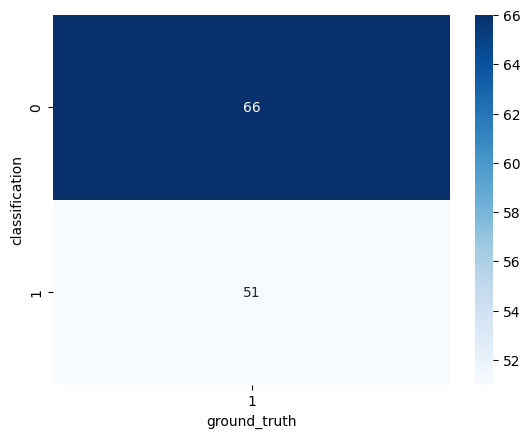

In [14]:
# heatmap for columnd: classification, ground_truth
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(df['classification'], df['ground_truth'], rownames=['classification'], colnames=['ground_truth'])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')